In [106]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import sys 
import os
from config import Config
%matplotlib inline

In [126]:
class DCGAN(object):
    def __init__(self, input, sess, config):
        self.input = input
        self.X, self.y = self.load_mnist_data()
        self.config = config
        self.sess = sess
        self.idx = 0
        self.iters = 0
        #print(self.X.shape, self.y.shape)
    def _leakyRelu(self, input, alpha, name='leakyRelu'):
        return tf.maximum(input, alpha * input, name=name)
        
    def _D_conv2d_bn(self, input, output_num, filter_size, stride, is_training=False, name=None):
        with tf.variable_scope(name) as scope:
            conv = tf.contrib.layers.conv2d(input, output_num, filter_size, stride, 
                                            'SAME', activation_fn=None) 
            bn = tf.contrib.layers.batch_norm(inputs=conv, is_training=is_training, activation_fn=None)
            return self._leakyRelu(bn, self.config.alpha)
        
    def _G_conv_transpose_bn(self, input, output_num, filter_size, stride, is_training, activate=True, name=None):
        with tf.variable_scope(name) as scope:
            conv_transpose = tf.contrib.layers.conv2d_transpose(
                input, output_num, filter_size, stride, 'SAME', 
                activation_fn=None, scope=name)
            bn = tf.contrib.layers.batch_norm(inputs=conv_transpose,
                                              is_training=is_training, 
                                              activation_fn=None, 
                                              scope=name)
            if activate:
                return tf.nn.relu(bn)
            else:
                return bn
        
    def discriminator(self, input, y=None, reuse=False, is_training=False):
        # LeNet-like discriminator
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()
            # d_0 = tf.contrib.layers.batch_norm(input, is_training=is_training, activation_fn=None, scope="input")
            d_1 = self._D_conv2d_bn(input, 8, 3, 2, is_training, name="D_conv1") # => [None, 14, 14, 8]
            d_2 = self._D_conv2d_bn(d_1, 16, 3, 1, is_training, name="D_conv2")  # => [None, 14, 14, 16]
            d_3 = self._D_conv2d_bn(d_2, 32, 3, 2, is_training, name="D_conv3")  # => [None, 7, 7, 32]
            d_4 = self._D_conv2d_bn(d_3, 64, 3, 1, is_training, name="D_conv4")  # => [None, 7, 7, 64]
            d_5 = tf.contrib.layers.flatten(d_4)
            d_6 = tf.contrib.layers.fully_connected(d_5, num_outputs=1, activation_fn=None, scope="D_linear")
            return tf.nn.sigmoid(d_6, name="D_output"), d_6
        
    def generator(self, input, reuse=False, is_training=False):
        with tf.variable_scope("generator") as scope:
            if reuse:
                scope.reuse_variable()
            g_0 = tf.cast(
                tf.contrib.layers.fully_connected(input, 7 * 7 * 128, 
                                                  activation_fn=None, 
                                                  scope="G_linear"), 
                dtype=tf.float32)
            # => [None, 4 * 4 * 1024]
            g_1 = tf.cast(tf.reshape(g_0, shape=[-1, 7, 7, 128]), dtype=tf.float32)
            g_2 = self._G_conv_transpose_bn(g_1, 64, 3, 2, is_training=is_training, name="G_conv_trans_1")
            g_3 = self._G_conv_transpose_bn(g_2, 32, 3, 1, is_training=is_training, name="G_conv_trans_2")
            g_4 = self._G_conv_transpose_bn(g_3, 16, 3, 2, is_training=is_training, name="G_conv_trans_3")
            g_5 = tf.contrib.layers.conv2d_transpose(g_4, 1, 3, 1, 'SAME', activation_fn=tf.nn.tanh, scope="G_conv_trans_4")
            return g_5
            
    def build(self, config):
        print("Building model...")
        self.is_training = tf.placeholder(bool, name="is_training")
        self.noise = tf.placeholder(shape=(None, config.latent_size),
                                    dtype=tf.float32, name="noise")
        self.real_image = tf.placeholder(shape=(config.batch_size, 28, 28, 1), 
                                         dtype=tf.float32, name="real_image")
        
        self._D_real, self.real_logits = self.discriminator(self.real_image,
                                                            y=None, 
                                                            is_training=self.is_training, 
                                                            reuse=False)
        self.fake_image = self.generator(self.noise, is_training=self.is_training)
        
        self._D_fake, self.fake_logits = self.discriminator(self.fake_image, 
                                                            y=None,
                                                            is_training=self.is_training, 
                                                            reuse=True)
        
        self.G_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fake_logits, 
                                                    labels=tf.ones_like(self._D_fake)))
        self.D_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fake_logits, 
                                                    labels=tf.zeros_like(self._D_fake)))
        
        self.D_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.real_logits, 
                                                    labels=tf.ones_like(self._D_real)))
        self.D_loss = self.D_loss_real + self.D_loss_fake
        
        self.G_image_sum = tf.summary.image("G_fake_image", self.fake_image)
        self.G_loss_sum = tf.summary.scalar("G_loss", self.G_loss)
        
        self.D_loss_sum = tf.summary.scalar("D_loss", self.D_loss)
        self.D_real_loss_sum = tf.summary.scalar("D_loss_real", self.D_loss_real)
        self.D_fake_loss_sum = tf.summary.scalar("D_loss_fake", self.D_loss_fake)
        
        self.G_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="generator") 
        self.D_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="discriminator")
        self.updata_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        self.G_trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="generator")
        self.D_trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="discriminator")
        self.trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
        self.G_sum = tf.summary.merge([self.G_image_sum, self.G_loss_sum])
        self.D_sum = tf.summary.merge([self.D_loss_sum, self.D_real_loss_sum, self.D_fake_loss_sum])
        
        self.train_summary_writer = tf.summary.FileWriter(config.summary_dir + "/train", self.sess.graph)
        self.test_summary_writer = tf.summary.FileWriter(config.summary_dir + "/test")
        
    def train(self, config):
        self.build(config)
        self.saver = tf.train.Saver()
        #sess = self.sess
        print("Starting training...")
        print("Model will be saved per %d epochs" %config.save_per_epoch)
        self.D_global_step = tf.Variable(0)
        self.G_global_step = tf.Variable(0)
        with tf.control_dependencies(self.D_update_ops):
            D_opt = tf.train.AdamOptimizer(learning_rate=config.lr, beta1=config.beta1) \
                            .minimize(self.D_loss, var_list=self.D_trainable_vars, global_step=self.D_global_step)
        with tf.control_dependencies(self.G_update_ops):
            G_opt = tf.train.AdamOptimizer(learning_rate=config.lr, beta1=config.beta1) \
                            .minimize(self.G_loss, var_list=self.G_trainable_vars, global_step=self.G_global_step)
        
        noise = np.random.uniform(-1, 1, [config.batch_size, config.latent_size])
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch in range(config.epoch_num):
            batch_ix = 0
            for X_batch, y_batch in self.minibatches(self.X, self.y, config.batch_size, True):
                feed_dict = {
                    self.real_image: X_batch.astype(np.float32), 
                    self.noise: noise,
                    self.is_training: True
                }
                
                _, train_D_loss, D_global_step, sum_str = self.sess.run(
                    [D_opt, self.D_loss, self.D_global_step, self.D_sum], feed_dict=feed_dict)
                self.train_summary_writer.add_summary(sum_str, D_global_step)
                
                _, train_G_loss, G_global_step, sum_str = self.sess.run(
                    [G_opt, self.G_loss, self.G_global_step, self.G_sum], feed_dict=feed_dict)
                self.train_summary_writer.add_summary(sum_str, G_global_step)
                
                _, train_G_loss, G_global_step, sum_str = self.sess.run(
                    [G_opt, self.G_loss, self.G_global_step, self.G_sum], feed_dict=feed_dict)
                self.train_summary_writer.add_summary(sum_str, G_global_step)
                batch_ix += 1
                sys.stdout.write("Epoch %d | %d / %d batches have been trained. G_loss: %.4f, D_loss: %.4f\r" 
                                 % (epoch, batch_ix, 70000 // config.batch_size, train_G_loss, train_D_loss))
                sys.stdout.flush()
            print("")
            if (epoch  +  1) % config.save_per_epoch == 0:
                sys.stdout.write("Saving model...\r")
                sys.stdout.flush()
                self.saver.save(self.sess, "models/saved_model.ckpt", global_step=D_global_step)
                sys.stdout.write(" " * 80 + "\r")
                sys.stdout.flush()
                print("Model saved at epoch %d" % epoch)
        print("")
        print("Training finished!")    
    def generate(self, num):
        #sess = self.sess
        noise = np.random.uniform(-1, 1, [num, config.latent_size])
        fake_image = self.sess.run(self.fake_image,
                             feed_dict={
                                 self.noise: noise,
                                 self.is_training: False
                             })
        return fake_image.reshape(num, 28, 28)
    
    def load_mnist_data(self, path="mnist.npz"):
        data = np.load(path)
        X = (np.concatenate((data["x_train"], data["x_test"]), axis=0)) / 255.0
        y = (np.concatenate((data["x_train"], data["x_test"]), axis=0)) / 255.0
        X = np.expand_dims(X, axis=3)
        return X, y
    
    def minibatches(self, inputs=None, targets=None, batch_size=None, shuffle=False):
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
        for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batch_size]
            else:
                excerpt = slice(start_idx, start_idx + batch_size)
            yield inputs[excerpt], targets[excerpt]

In [127]:
NUM_GENERATED = 9

tf.reset_default_graph()
sess = tf.Session()

config = Config(
    batch_size=64, 
    latent_size=100, 
    lr=0.0002, 
    epoch_num=3, 
    beta1=0.5, 
    alpha=0.2, 
    save_per_epoch=5)

test_input = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)
test_model = DCGAN(test_input, tf.Session(), config)
test_model.train(config)

Building model...
Starting training...
Model will be saved per 5 epochs
Epoch 0 | 1093 / 1093 batches have been trained. G_loss: 0.7080, D_loss: 1.4373
Epoch 1 | 1093 / 1093 batches have been trained. G_loss: 0.6859, D_loss: 1.4333
Epoch 2 | 1093 / 1093 batches have been trained. G_loss: 0.6832, D_loss: 1.3916

Training finished!


In [128]:
generated_images = test_model.generate(NUM_GENERATED)

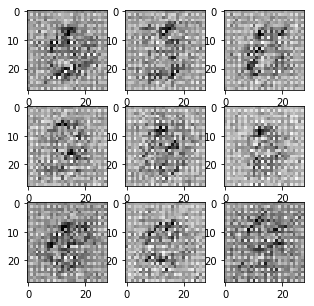

In [129]:
tmp = int(np.sqrt(NUM_GENERATED))
f, axarr = plt.subplots(tmp, tmp, figsize=(5, 5))
for i in range(tmp):
    for j in range(tmp):
        axarr[i, j].imshow(generated_images[i*tmp + j], cmap='Greys', interpolation='nearest')


In [70]:
f.savefig("output.png")